In [1]:
### loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



In [2]:
# Load Data
train = pd.read_csv('/rds/general/user/wq21/projects/hda_21-22/live/TDS/Group_2/TDS-Group-Project/Analysis/SVM/Sens_colon/train_5_year.csv',low_memory=False)
test = pd.read_csv('/rds/general/user/wq21/projects/hda_21-22/live/TDS/Group_2/TDS-Group-Project/Analysis/SVM/Sens_colon/test_5_year.csv',low_memory=False)

def get_results(truth, prediction, df, idx):
    
    y_test2 = truth.map({'healthy':0, 'case':1})
    y_pred2 = pd.Series(prediction).map({'healthy':0, 'case':1})


    acc = accuracy_score(y_test2, y_pred2)
    f1 = f1_score(y_test2, y_pred2)
    precision = precision_score(y_test2, y_pred2)
    recall = recall_score(y_test2, y_pred2)

    df.loc[idx,:] = [acc, f1, precision, recall]

    return df

results = pd.DataFrame(columns = ['accuracy','f1','precision','recall'])

y_train = train['cc_status'] 
y_train = y_train.astype('category')
y_train = y_train.map({0: 'healthy', 1: 'case'})
y_test = test['cc_status'] 
y_test = y_test.astype('category')
y_test = y_test.map({0: 'healthy', 1: 'case'})
y_train.describe()

X_train = train.iloc[:,2:]
X_test = test.iloc[:,2:]
X_train.isnull().sum()[X_train.isnull().sum()>0]


Series([], dtype: int64)

           accuracy        f1 precision    recall
SVM_linear  0.54002  0.419437  0.363636  0.495468


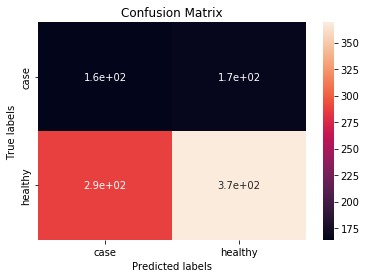

In [3]:
# Apply linear SVM

## Using all data

svm_class = svm.SVC(kernel = 'linear', class_weight= {'healthy': 1, 'case': 2},
                    gamma='auto', random_state = 8,  probability = True)
svm_class.fit(X_train, y_train)

y_pred = svm_class.predict(X_test)

labels = ['case', 'healthy']
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['case', 'healthy']); ax.yaxis.set_ticklabels(['case', 'healthy'])

plt.savefig("Outputs_5year/SVM_linear_cm.pdf")

results = get_results(y_test, y_pred, results, 'SVM_linear')

print(results)

In [4]:
# RBF kernal
y_train2 = y_train.map({'healthy':0, 'case':1})

num_features = np.size(X_train, axis=1)
param_grid = {'C': [0.01, 0.1, 1,5,10,100], 
   'gamma': [3,2,1, 0.1, 0.01, 0.001], 
   'kernel': ['rbf']}
## NOTE: We are includeing C=1 and gamma=1/(num_features * X_train_scaled.var())

optimal_params = GridSearchCV(
    svm.SVC(class_weight= {0: 1, 1: 2}), 
    param_grid,
    cv=5,
    scoring='roc_auc', 
    verbose=0,
    n_jobs = 7
    )

optimal_params.fit(X_train, y_train2)
print(optimal_params.best_params_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [5]:
# RBF fine tune
y_train2 = y_train.map({'healthy':0, 'case':1})

num_features = np.size(X_train, axis=1)
param_grid = {'C': [0.2,0.4,0.6,0.8,1,2,3,4], 
   'gamma': list(np.arange(0.001, 0.01, 0.001)), 
   'kernel': ['rbf']}

optimal_params = GridSearchCV(
    svm.SVC(class_weight= {0: 1, 1: 2}), 
    param_grid,
    cv=5,
    scoring='roc_auc', 
    verbose=0,
    n_jobs = 7
    )

optimal_params.fit(X_train, y_train2)
print(optimal_params.best_params_)


{'C': 0.4, 'gamma': 0.001, 'kernel': 'rbf'}
